<ipython-input-5-49b14f63f5eb>:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  candlestick_data[f'{col}_lag_{i}'] = candlestick_data[col].shift(i)
<ipython-input-5-49b14f63f5eb>:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  candlestick_data[f'{col}_lag_{i}'] = candlestick_data[col].shift(i)
<ipython-input-5-49b14f63f5eb>:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

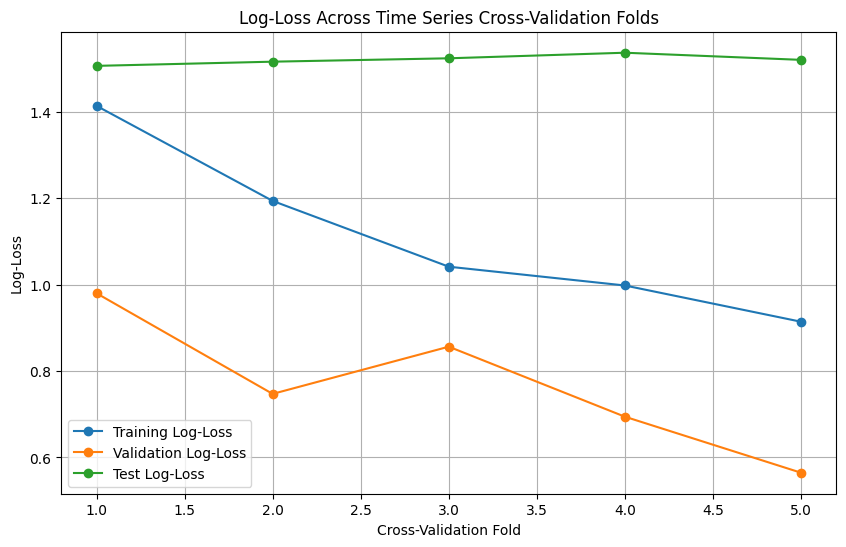

Final Log-Loss on Test Set: 1.5202
Final Accuracy on Test Set: 0.6141

Confusion Matrix:
[[ 83   0  10   7   0   3   1   3   0   0   2   0   1   0   0   0   0]
 [  0  98   0   0   0   0  10   0   1   0   1   0   0   0   0   0   0]
 [  0   0  38   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0 150   0   1   5   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  12   0   0   0   0   0   0   0   0   0   0   0   0]
 [  5   0   2   0   0  81   2   0   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  67   0   0   0   0   0   0   0   0   3   0]
 [  9   0   4   0   0   3   0  75   0   0   0   0   2   1   0   0   0]
 [  0   0   0   0   0   0   4   0  49   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  69   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  26   0   0   0   0   0]
 [  0   0   4   0   0   0   0   0   0   0   0   0  63   0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Load the dataset
file_path = 'refined_candlestick_patterns1.csv'
candlestick_data = pd.read_csv(file_path)

# Step 2: Feature Engineering
# Calculate technical indicators: EMA, Bollinger Bands, MACD, and candlestick-specific features
candlestick_data['EMA_5'] = candlestick_data['Close'].ewm(span=5, adjust=False).mean()
candlestick_data['EMA_10'] = candlestick_data['Close'].ewm(span=10, adjust=False).mean()
candlestick_data['EMA_20'] = candlestick_data['Close'].ewm(span=20, adjust=False).mean()

candlestick_data['BB_Middle'] = candlestick_data['Close'].rolling(window=20).mean()
candlestick_data['BB_Upper'] = candlestick_data['BB_Middle'] + 2 * candlestick_data['Close'].rolling(window=20).std()
candlestick_data['BB_Lower'] = candlestick_data['BB_Middle'] - 2 * candlestick_data['Close'].rolling(window=20).std()

ema_12 = candlestick_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = candlestick_data['Close'].ewm(span=26, adjust=False).mean()
candlestick_data['MACD'] = ema_12 - ema_26
candlestick_data['MACD_Signal'] = candlestick_data['MACD'].ewm(span=9, adjust=False).mean()

candlestick_data['Body_Size'] = abs(candlestick_data['Close'] - candlestick_data['Open'])
candlestick_data['Upper_Wick'] = candlestick_data['High'] - candlestick_data[['Open', 'Close']].max(axis=1)
candlestick_data['Lower_Wick'] = candlestick_data[['Open', 'Close']].min(axis=1) - candlestick_data['Low']
candlestick_data['Body_Wick_Ratio'] = candlestick_data['Body_Size'] / (candlestick_data['Upper_Wick'] + candlestick_data['Lower_Wick'] + 1e-6)

# Step 3: Create deeper sliding window features (10 candles back)
window_size = 10  # Deeper window
columns_to_shift = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'MACD', 'MACD_Signal']

for i in range(1, window_size):
    for col in columns_to_shift:
        candlestick_data[f'{col}_lag_{i}'] = candlestick_data[col].shift(i)

# Drop rows with NaN values generated during feature calculation
candlestick_data.dropna(inplace=True)

# Step 4: Encode categorical columns: 'Trend' and 'Candlestick Pattern'
label_encoder_trend = LabelEncoder()
candlestick_data['Trend'] = label_encoder_trend.fit_transform(candlestick_data['Trend'])

label_encoder_pattern = LabelEncoder()
candlestick_data['Candlestick Pattern'] = label_encoder_pattern.fit_transform(candlestick_data['Candlestick Pattern'])

# Step 5: Data Augmentation (Jittering and Scaling)
def augment_data(data, jitter_factor=0.01, scale_factor=0.05, n_augmentations=2):
    augmented_data = []
    for _ in range(n_augmentations):
        # Jitter: Add small random noise to OHLC values
        jittered_data = data.copy()
        jittered_data['Open'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['High'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['Low'] *= (1 + jitter_factor * np.random.randn(len(data)))
        jittered_data['Close'] *= (1 + jitter_factor * np.random.randn(len(data)))

        # Scaling: Slightly scale the entire pattern
        scaling_factor = 1 + scale_factor * np.random.randn()
        jittered_data[['Open', 'High', 'Low', 'Close']] *= scaling_factor

        augmented_data.append(jittered_data)

    # Combine original and augmented data
    augmented_data = pd.concat([data] + augmented_data, ignore_index=True)
    return augmented_data

# Apply data augmentation to the original dataset
augmented_candlestick_data = augment_data(candlestick_data, jitter_factor=0.01, scale_factor=0.05, n_augmentations=3)

# Step 6: Separate features and target variable
X = augmented_candlestick_data.drop(columns=['Start', 'End', 'Candlestick Pattern'])
y = augmented_candlestick_data['Candlestick Pattern']

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 8: Apply SMOTE with Tomek Links to handle class imbalance
smote_tomek = SMOTETomek(smote=SMOTE(k_neighbors=1), random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Step 9: Initialize the RandomForestClassifier (without hyperparameter tuning)
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')

# Step 10: Cross-Validation for Log-Loss Tracking
log_losses_train = []
log_losses_val = []
log_losses_test = []

tscv = TimeSeriesSplit(n_splits=5)

for train_index, val_index in tscv.split(X_resampled):
    X_train_cv, X_val_cv = X_resampled[train_index], X_resampled[val_index]
    y_train_cv, y_val_cv = y_resampled[train_index], y_resampled[val_index]

    # Train the model
    rf_classifier.fit(X_train_cv, y_train_cv)

    # Predict probabilities for log-loss calculation (Training set)
    y_train_pred_prob = rf_classifier.predict_proba(X_train_cv)
    train_log_loss = log_loss(y_train_cv, y_train_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
    log_losses_train.append(train_log_loss)

    # Predict probabilities for log-loss calculation (Validation set)
    y_val_pred_prob = rf_classifier.predict_proba(X_val_cv)
    val_log_loss = log_loss(y_val_cv, y_val_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
    log_losses_val.append(val_log_loss)

    # Predict probabilities for log-loss calculation (Test set)
    y_test_pred_prob = rf_classifier.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
    log_losses_test.append(test_log_loss)

# Plot log-loss graph for training, validation, and test sets
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(log_losses_train) + 1), log_losses_train, marker='o', label='Training Log-Loss')
plt.plot(range(1, len(log_losses_val) + 1), log_losses_val, marker='o', label='Validation Log-Loss')
plt.plot(range(1, len(log_losses_test) + 1), log_losses_test, marker='o', label='Test Log-Loss')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Log-Loss')
plt.title('Log-Loss Across Time Series Cross-Validation Folds')
plt.legend()
plt.grid(True)
plt.show()

# Step 11: Evaluate the tuned model on the test set
y_test_pred_prob = rf_classifier.predict_proba(X_test)
y_test_pred = rf_classifier.predict(X_test)

# Calculate log-loss and accuracy for the test set
final_log_loss = log_loss(y_test, y_test_pred_prob, labels=np.arange(len(label_encoder_pattern.classes_)))
final_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=np.arange(len(label_encoder_pattern.classes_)))
classification_report_final = classification_report(y_test, y_test_pred, labels=np.arange(len(label_encoder_pattern.classes_)), target_names=label_encoder_pattern.classes_)

# Print results
print(f"Final Log-Loss on Test Set: {final_log_loss:.4f}")
print(f"Final Accuracy on Test Set: {final_accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_final)
